# Simple nn for black boxes ( [this article](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) and [this tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) )

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

Start

In [2]:
num_imgs = 20000

img_size = 10
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

((20000, 10, 10), (20000, 1, 4))

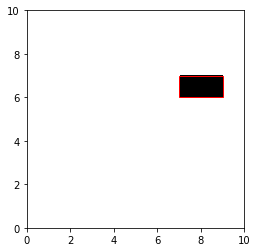

In [3]:
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [100]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = ( imgs - imgs.mean() )/imgs.std()
X.shape, np.mean(X), np.std(X)

((20000, 10, 10), -8.50555181841628e-17, 0.9999999999999998)

In [174]:
# Normalize x, y, w, h by img_size
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

((20000, 4), -0.22534375, 0.19016458486252769)

In [175]:
# Split training and test.
i = int(0.8 * num_imgs)
X_train = X[:i]
X_test = X[i:]
y_train = y[:i]
y_test = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [176]:
X_train.shape

(16000, 10, 10)

In [177]:
# Use torch data format
X_train = torch.FloatTensor(X_train).unsqueeze(1) #Add one dimension to the tensor
X_test  = torch.FloatTensor(X_test).unsqueeze(1)

y_train = torch.FloatTensor(y_train)
y_test  = torch.FloatTensor(y_test)

In [178]:
X_train.shape

torch.Size([16000, 1, 10, 10])

In [179]:
import torch
from torch import nn
import torch.nn.functional as F

In [180]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 3, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear( 3, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


In [181]:
params = list(model.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([3, 1, 3, 3])
torch.Size([3, 3, 3, 3])


In [182]:
# Check that network passes data
input = torch.randn(1, 1, 10, 10)
out = model(input)

In [183]:
out

tensor([[ 0.0599,  0.0387,  0.0624, -0.0641]], grad_fn=<AddmmBackward>)

In [185]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), 5e-1) #Adam

In [186]:
def train(num_epoch):
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        model.train(True)
        #Loss
        y_pred = model(X_train)
        train_loss = loss_fn(y_pred, y_train)
        train_losses.append( float(train_loss) )
        #zero grad
        optimizer.zero_grad()
        #back prop
        train_loss.backward()
        #update weigths
        optimizer.step()

        model.train(False)
        y_pred = model(X_test)
        test_loss = loss_fn(y_pred, y_test)
        test_losses.append( float(test_loss) )
        
        train_l = float(train_loss)
        test_l = float(test_loss)
        print('Epoch:', i, f'Train loss: {train_l:.4f}; Test loss: {test_l:.4f}',)

    return train_losses, test_losses

Epoch: 0 Train loss: 0.0252; Test loss: 0.0250
Epoch: 1 Train loss: 0.0246; Test loss: 0.0244
Epoch: 2 Train loss: 0.0241; Test loss: 0.0240
Epoch: 3 Train loss: 0.0236; Test loss: 0.0236
Epoch: 4 Train loss: 0.0232; Test loss: 0.0232
Epoch: 5 Train loss: 0.0228; Test loss: 0.0229
Epoch: 6 Train loss: 0.0224; Test loss: 0.0226
Epoch: 7 Train loss: 0.0221; Test loss: 0.0223
Epoch: 8 Train loss: 0.0218; Test loss: 0.0220
Epoch: 9 Train loss: 0.0216; Test loss: 0.0218
Epoch: 10 Train loss: 0.0213; Test loss: 0.0215
Epoch: 11 Train loss: 0.0211; Test loss: 0.0213
Epoch: 12 Train loss: 0.0208; Test loss: 0.0211
Epoch: 13 Train loss: 0.0206; Test loss: 0.0208
Epoch: 14 Train loss: 0.0204; Test loss: 0.0206
Epoch: 15 Train loss: 0.0201; Test loss: 0.0204
Epoch: 16 Train loss: 0.0199; Test loss: 0.0201
Epoch: 17 Train loss: 0.0196; Test loss: 0.0199
Epoch: 18 Train loss: 0.0194; Test loss: 0.0196
Epoch: 19 Train loss: 0.0191; Test loss: 0.0193
Epoch: 20 Train loss: 0.0188; Test loss: 0.0190
Ep

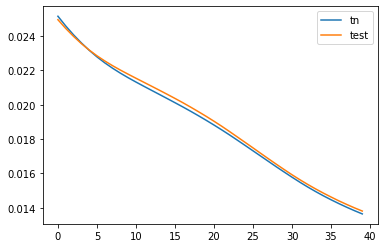

In [188]:
train_losses, test_losses = train(40)
plt.plot(range(len(train_losses)), train_losses, label='tn')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()

In [169]:
y_pred = model(X_test)

In [170]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

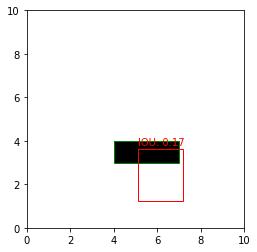

In [171]:
import random
i = random.randint(0, 700)
plt.imshow(X_test[i].numpy().reshape((10,-1)).T, 
           cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
pred_bbox = y_pred[i].detach().numpy()*img_size
plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
exp_bbox = y_test[i].numpy()*img_size
plt.gca().add_patch(matplotlib.patches.Rectangle((exp_bbox[0], exp_bbox[1]), exp_bbox[2], exp_bbox[3], ec='g', fc='none'))
plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r');

In [172]:
pred_bboxes = y_pred.detach().numpy()*img_size
test_bboxes = y_test.numpy()*img_size

In [173]:
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

0.1602608476452224